In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
input_size = 28
num_classes = 10
num_epochs =3
batch_size =64

train_dataset =datasets.MNIST(root = './',train = True, transform  = transforms.ToTensor(),download=True)
test_dataset =datasets.MNIST(root = './',train = False, transform  = transforms.ToTensor(),download=True)

train_loader =torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader =torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 =nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32*7*7,10)
    def forward(self,x):
        x =self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        out = self.out(x)
        return out

In [9]:
def acc(predicitons,labels):
    pred = torch.max(predicitons.data,1)[1]
    rights =pred.eq(labels.data.view_as(pred)).sum()
    return rights,len(labels)

In [18]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10  # Adjust this as needed

for epoch in range(num_epochs):
    start_time =time.time()
    train_right = []

    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data,target = data.to(device),target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = acc(output, target)
        train_right.append(right)

    model.eval()
    val_right = []

    for (data, target) in test_loader:
        data,target = data.to(device),target.to(device)
        output = model(data)
        right = acc(output, target)
        val_right.append(right)

    train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
    val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
    
    end_time =time.time()
    total =end_time-start_time
    print(f'當前epoch: {epoch+1}, loss: {loss.item():.4f}, acc: {100 * train_r[0] / train_r[1]:.2f}%,花費時間:{total:.2f}秒')

當前epoch: 1, loss: 0.0057, acc: 94.14%,花費時間:1.63秒
當前epoch: 2, loss: 0.0710, acc: 98.17%,花費時間:1.66秒
當前epoch: 3, loss: 0.0219, acc: 98.75%,花費時間:1.62秒
當前epoch: 4, loss: 0.0031, acc: 98.93%,花費時間:1.71秒
當前epoch: 5, loss: 0.0122, acc: 99.07%,花費時間:1.69秒
當前epoch: 6, loss: 0.0049, acc: 99.31%,花費時間:1.65秒
當前epoch: 7, loss: 0.0025, acc: 99.39%,花費時間:1.63秒
當前epoch: 8, loss: 0.0007, acc: 99.51%,花費時間:1.63秒
當前epoch: 9, loss: 0.0001, acc: 99.46%,花費時間:1.62秒
當前epoch: 10, loss: 0.0027, acc: 99.68%,花費時間:1.68秒


In [23]:
import zipfile
f = zipfile.ZipFile("./flowers.zip",'r') # 原壓縮文件在服務器的位置
for file in f.namelist():
    f.extract(file,"./") #解壓到的位置，./表示當前目錄(與此.ipynb文件同一個目錄)
f.close()

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import imageio,time,warnings,random,sys,copy
from PIL import Image

In [28]:
data_dir = './flowers'
train = data_dir+'/train'
valid= data_dir+'/valid'

In [29]:
data_transform = {
    'train':transforms.Compose([transforms.RandomRotation(45),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(brightness=0.2,contrast=0.1,saturation=0.1,hue=0.1),
                        transforms.RandomGrayscale(p=0.025),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
    'valid':transforms.Compose([transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
}  

In [30]:
batch_size = 8

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transform[x]) for x in ['train','valid']}
dataloaders ={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid']}
dataset_size = {x:len(image_datasets[x]) for x in ['train','valid']}
class_numes = image_datasets['train'].classes

In [31]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3252
     Root location: ./flowers/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 1065
     Root location: ./flowers/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  

In [32]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fbce9177eb0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fbce9177910>}

In [33]:
dataset_size

{'train': 3252, 'valid': 1065}

In [34]:
class_numes

['1', '2', '3', '4', '5']

In [35]:
def im_convert(tensor):
    
    image = torch.tensor.to('cpu').clone.detach()
    imgae = image.np().squeeze()
    image = image.transpose(1,2,0)

TypeError: imshow() missing 1 required positional argument: 'X'

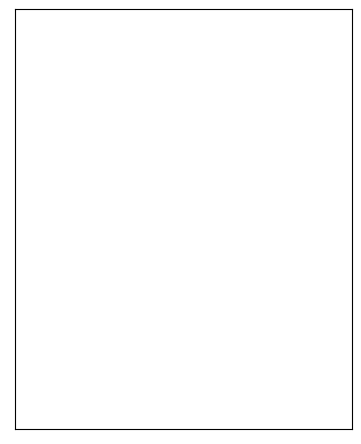

In [37]:
fig = plt.figure(figsize = (20,12))
colums =4
row=2

dataiter = iter(dataloaders['valid'])
input,classes = dataiter.next()

for idx in range(colums*row):
    ax = fig.add_subplot(row,colums,idx+1,xticks=[],yticks=[])
    plt.imshow()